# DREAMix
This tutorial is a walk-through of our DREAMix project for the 2024 DREAM Challenge of Olfactory Mixture Prediction. It will highlight some of the key steps we took to design our models to handle permutation invariance, pre-training with large datasets, and high predictive performance.

DREAMix is a combination of a graph neural network (POM), a transformer neural network (CheMix), and a generalized linear model (GLM) that takes in molecules from pairs of mixtures and predicts the olfactory similarity between the mixtures. The POM is pre-trained on single molecule odor datasets, while the CheMix is pre-trained on mixture odor datasets. The purpose of the GLM is to flexibly compute the correct loss functions and post-processing for each task type. The DREAMix model is fine-tuned end-to-end on the DREAM challenge dataset to generate the final submission results. We show the results at the end of the notebook.


The following image is a visualization of our pipeline, and some of our best results.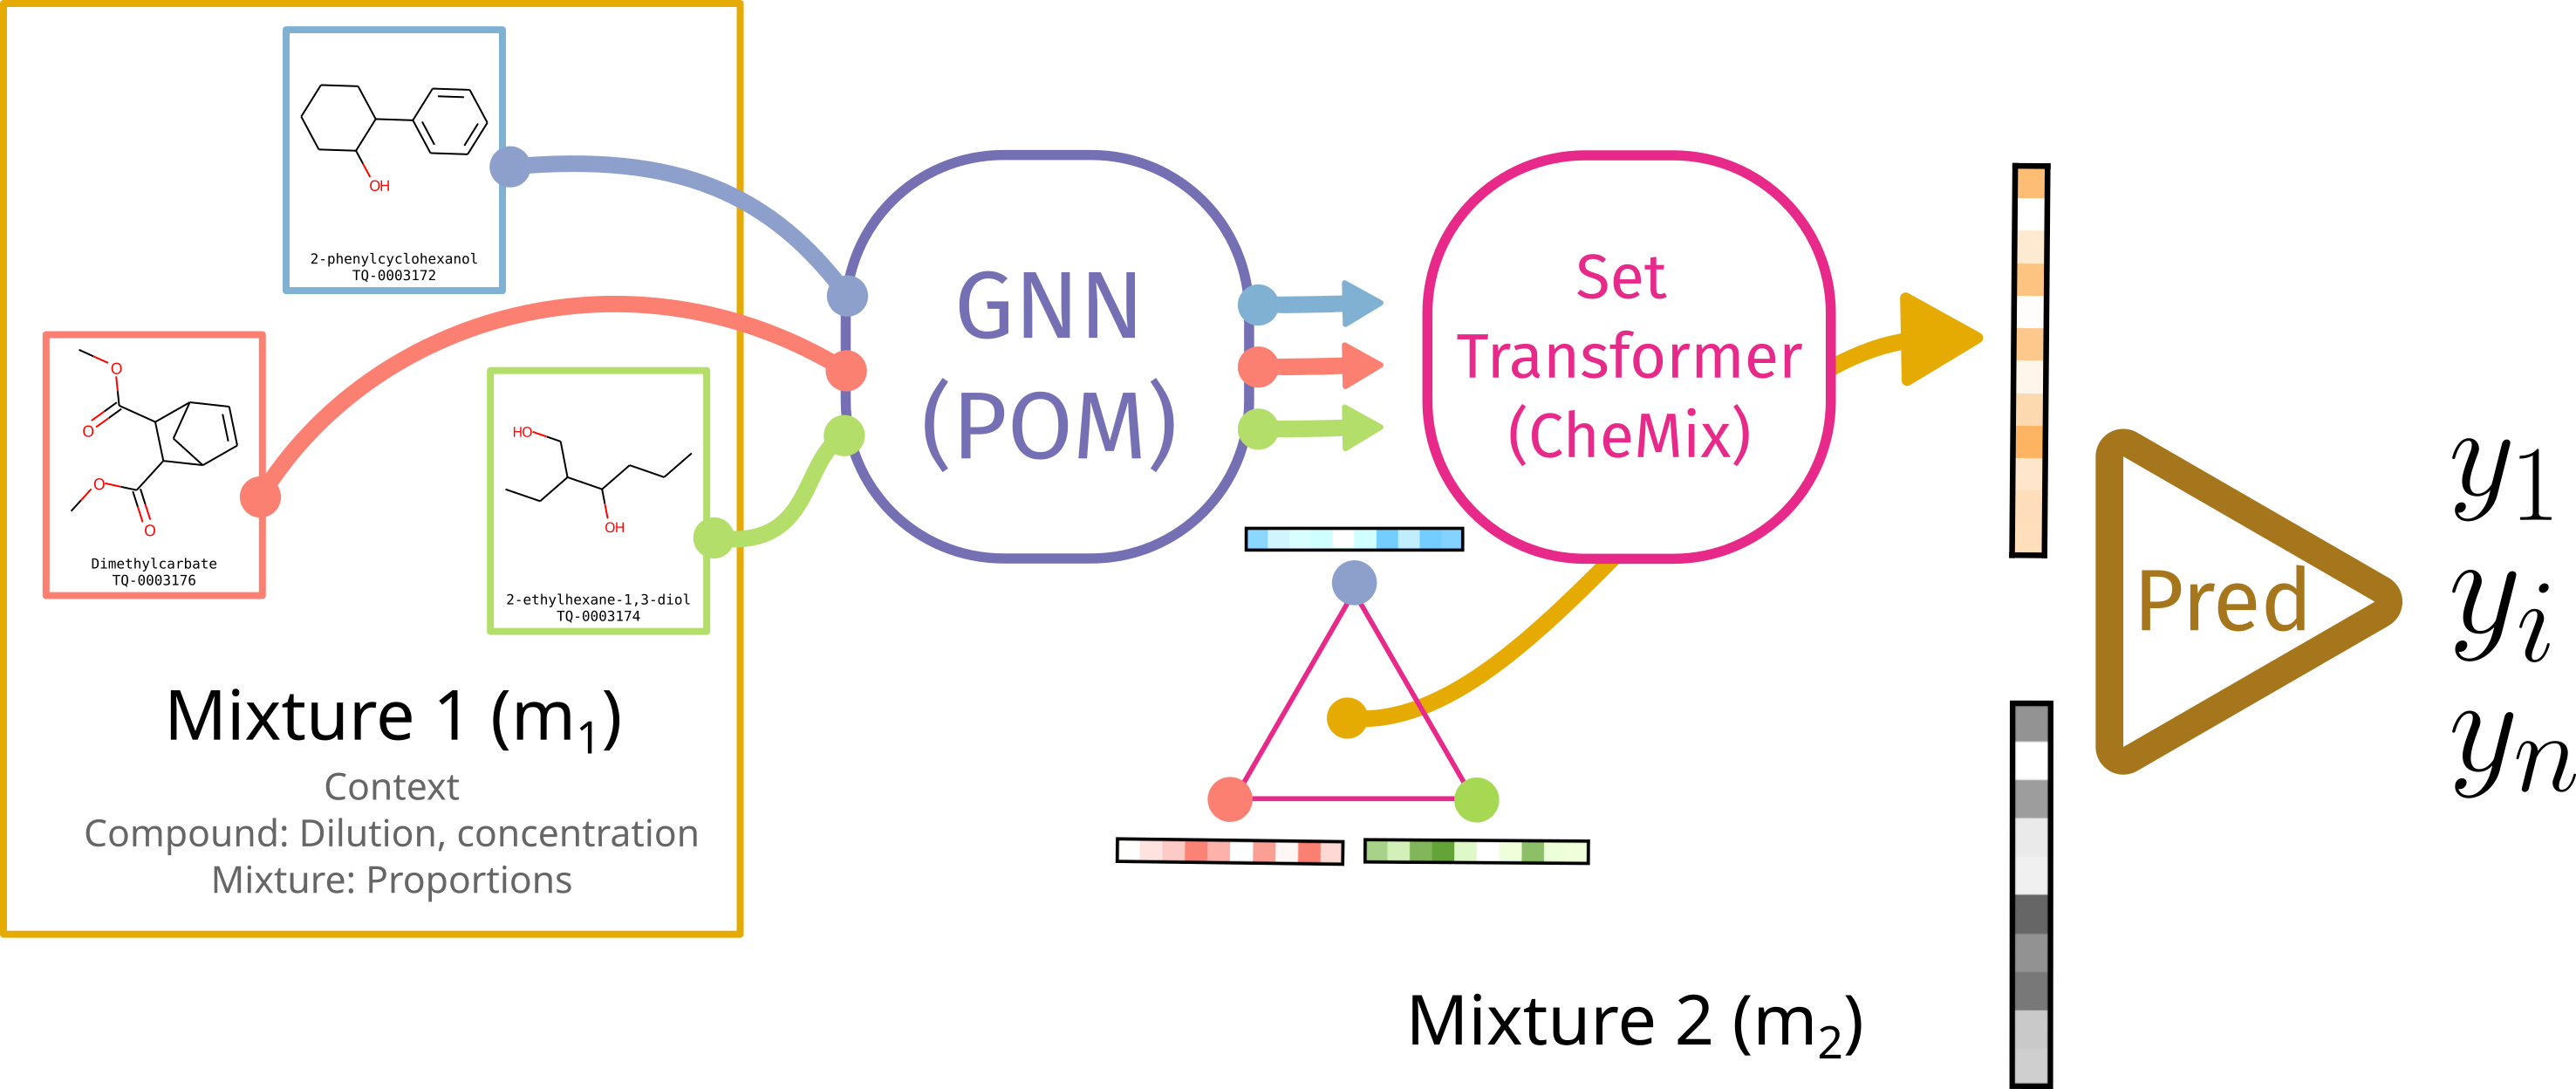

## Setup

generate your own token at https://github.com/settings/tokens, token is only needed while the github is private.

In [6]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    token=""
    !rm -rf dreamix
    !rm -rf sample_data
    !git clone https://{token}@github.com/chemcognition-lab/dreamix.git
    %cd dreamix
    !pip install -r colab_requirements.txt
    sys.path.append('/content/dreamix/src')
    fname = f'' 
else:
    print('Not in colab, assuming your have your kernel setup')
    sys.path.append("../src")
    fname = f'../' 

Not in colab, assuming your have your kernel setup


In [7]:
import json
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torchinfo
import torchmetrics.functional as F
import tqdm
from ml_collections import ConfigDict
from torch_geometric.data import Batch

from chemix.model import build_chemix
from chemix.data import get_mixture_smiles
from chemix.train import LOSS_MAP
from chemix.utils import TORCH_METRIC_FUNCTIONS
from dataloader import DreamLoader
from dataloader.representations.graph_utils import EDGE_DIM, NODE_DIM, from_smiles
from pom.early_stop import EarlyStopping
from pom.gnn.graphnets import GraphNets

## Modelling
The main design feature of the DREAMix model is naturally accounting for the symmetries (molecular graph, order of molecules, and order of mixtures) present in the olfactory mixture dataset.

We start with a graph neural network (POM) that is permutation invariant to the graph input to encode molecules because molecules are naturally represented as graphs (atoms and bonds).

We then use the graph embeddings from the POM from each molecule in the pair of mixtures. These embeddings are passed to a permutation invariant transformer neural network. In other words, the order of the molecules in a mixture does not matter. The order of the mixtures also does not matter and we account for this by using cosine similarity on the mixture embeddings which is permutation invariant since it is calculating the distance between the two mixture embeddings.

These 3 symmetries (molecular graph, order of molecules, and order of mixtures) are all accounted for to produce a permutation invariant model that will offer better performance and reliability.

## Primary Odor Map (POM) Neural Network
The POM is pre-trained on odor-related property prediction datasets whereby the molecular embedding is ultimately used for the CheMix model.

The POM architecture is shown below.

The EdgeFiLM layer applies feature-wise linear modulation (sigmoidal gating) over the edge updates for improving the model's ability to reason.

The NodeAttn layer is a graph attention transformer network which applies self-attention to the relevant nodes.

The GlobalPNA layer applies principal neighbourhood aggregation (avg, min, max, std) over the nodes.

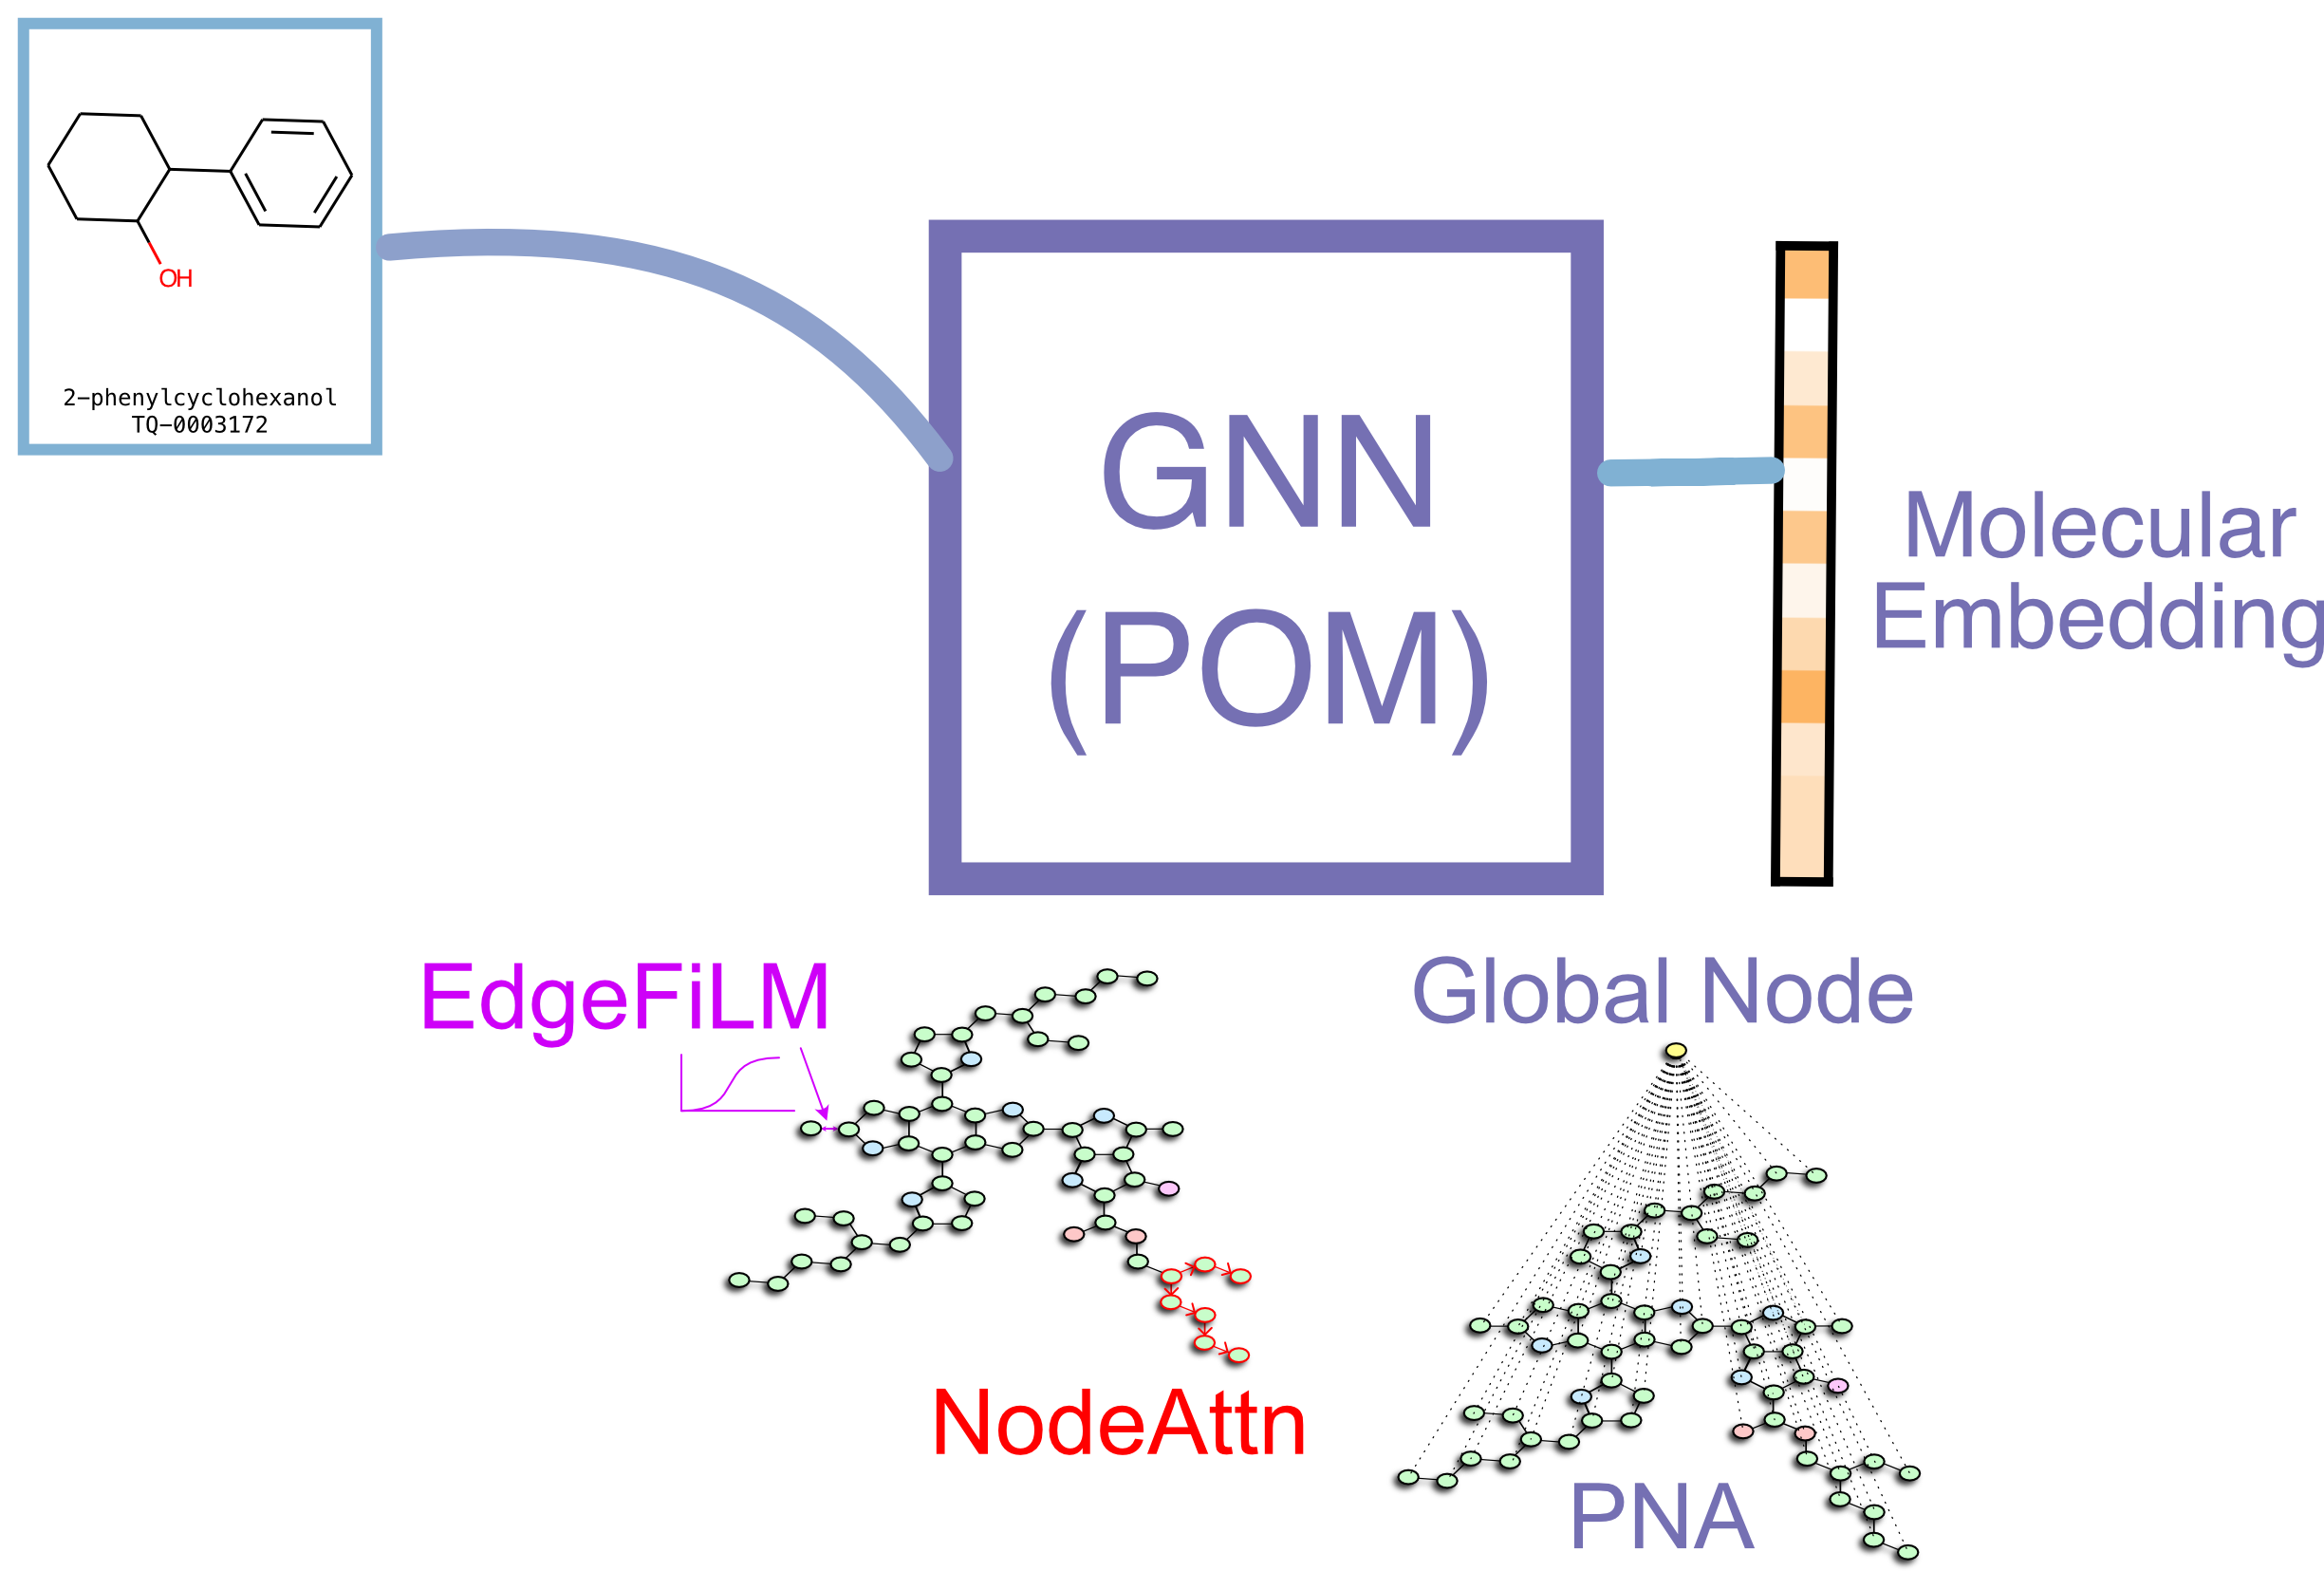

In [8]:
scripts_chemix_path = f'{fname}scripts_chemix/results/chemix_ensemble/top1'
# using hyperparameters
hp_gnn = ConfigDict(json.load(open(f'{scripts_chemix_path}/hparams_graphnets.json', 'r')))
# create the pom embedder model
embedder = GraphNets(node_dim=NODE_DIM, edge_dim=EDGE_DIM, **hp_gnn)
embedder.load_state_dict(torch.load(f'{scripts_chemix_path}/gnn_embedder.pt', map_location=torch.device('cpu')))
torchinfo.summary(embedder)

Layer (type:depth-idx)                                       Param #
GraphNets                                                    --
├─ModuleList: 1-1                                            --
│    └─MetaLayer: 2-1                                        --
│    │    └─EdgeFiLMModel: 3-1                               10,416
│    │    └─NodeAttnModel: 3-2                               37,359
│    │    └─GlobalPNAModel: 3-3                              94,916
│    └─MetaLayer: 2-2                                        --
│    │    └─EdgeFiLMModel: 3-4                               10,276
│    │    └─NodeAttnModel: 3-5                               37,359
│    │    └─GlobalPNAModel: 3-6                              94,276
│    └─MetaLayer: 2-3                                        --
│    │    └─EdgeFiLMModel: 3-7                               10,276
│    │    └─NodeAttnModel: 3-8                               37,359
│    │    └─GlobalPNAModel: 3-9                              94,276

### Inputs
The input into the POM is a single molecular graph.
Specifically, the IsomericSMILES are processed using RDKit and converted into a graph, `G = (N, E)`, where atoms are nodes and bonds are edges, `G = (A, B)`. The nodes contain atom descriptors, and edges contain bond descriptors.

The input dimension: `[batch_size, node_dim, edge_dim]`

### Outputs
The output of the POM are odor-related properties of the molecule. After pre-training, the molecular embedding is generated for the molecules that will be later used in the CheMix model.

The output embedding dimension: `[batch_size, global_dim]`

The output dimension: `[batch_size, task_dim]`


## Principle Component Analysis of POM Embedding Space (from GoodScents-Leffingwell Dataset)
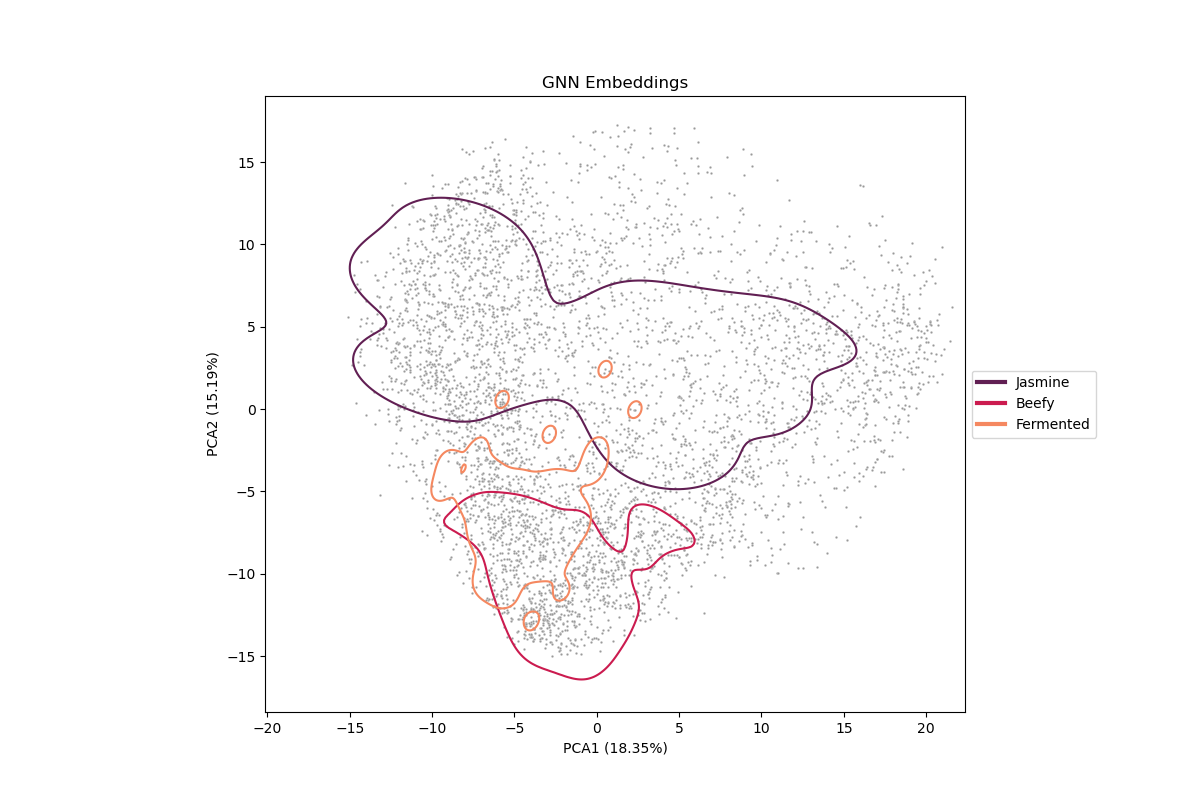

## CheMix

The CheMix is pre-trained on odor-related mixture property prediction datasets.

The CheMix architecture is shown below.

The CheMix consists of a self-attention transformer layer and a cross-attention transformer layer.

We seeks three types of symmetries for layers and models of mixtures and sets of mixtures:
1. Permutation Equivariance (PE) for mixture layers, that is to say, a permutation on a input mixture should return a permuted output (mixture tensors). 
2. Permutation Invariance (PI) for mixture aggregators, that is to say, the order of compounds in a mixture should not affect the output (mixture embeddings).
2. Permutation Invariance (PI) for the pairs of mixtures, that is to say, the order of mixtures in a set should not affect the output (similary score for example).

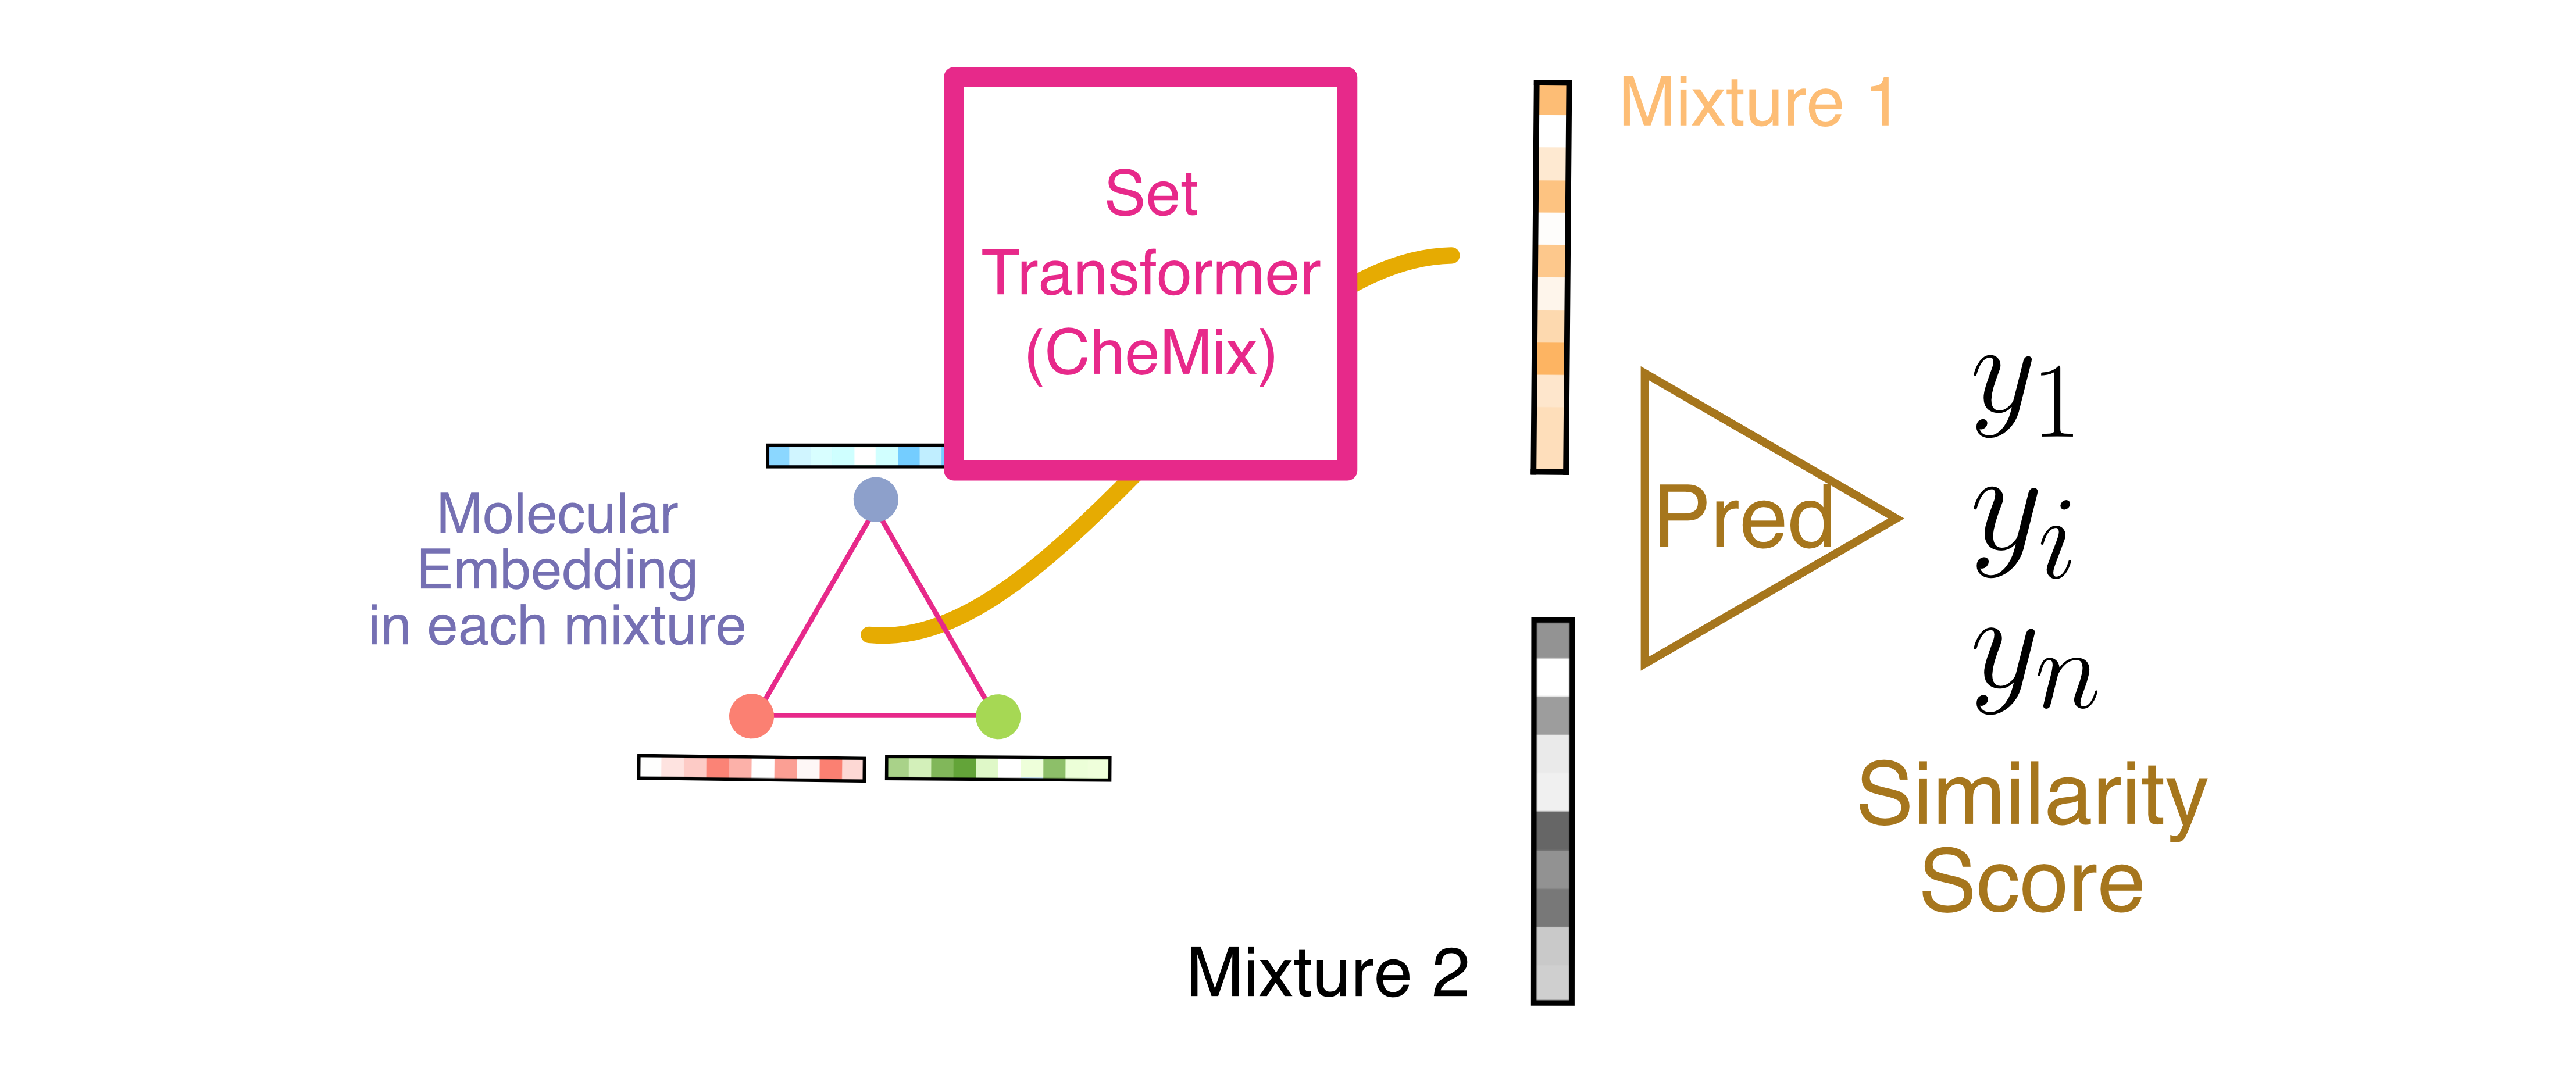

In [9]:
# using hyperparameters
config = ConfigDict(json.load(open(f'{scripts_chemix_path}/hparams_chemix.json', 'r')))
# create the pom embedder model
model = build_chemix(config=config.chemix).to(device="cpu")
torchinfo.summary(model, input_size=(config.batch_size, 43, config.chemix.pom_input.embed_dim, config.chemix.pom_input.num_mix))

/Users/stanl/opt/anaconda3/envs/DREAM/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                             Output Shape              Param #
Chemix                                             [500, 1]                  --
├─Linear: 1-1                                      [500, 43, 128]            25,216
├─MixtureBlock: 1-2                                [500, 128]                --
│    └─ModuleList: 2-4                             --                        (recursive)
│    │    └─MolecularAttention: 3-1                [500, 43, 128]            99,584
│    │    └─MolecularAttention: 3-2                [500, 43, 128]            99,584
│    │    └─MolecularAttention: 3-3                [500, 43, 128]            99,584
│    └─PrincipalNeighborhoodAggregation: 2-2       [500, 512]                --
│    └─MLP: 2-3                                    [500, 128]                --
│    │    └─Sequential: 3-4                        [500, 128]                65,664
├─Linear: 1-3                                      [500, 43, 128]            (recursiv

### Inputs
The input to the CheMix is a pair of mixtures of molecules. Each molecule in the mixtures are converted into a molecular embedding using the POM.

The input dimension: `[batch_size, num_of_max_molecules, molecular_embedding_dim]`

The self-attention layer is used to learn the importance of each molecule in a mixture. In other words, which molecule contributes the most odor to the whole mixture? 

Next, the molecular embedding dimension is reduced using molecular aggregation such as mean, PNA, etc. Then, the cross-attention layer is used to generate a mixture embedding. In other words, what information from the molecule aggregation is important to the odor of the mixture? The similarity between the two mixtures in the pair are compared using cosine similarity.

### Outputs
The output of the CheMix is a similarity score between the pair of mixtures.

The output dimension: `[batch_size, 1]`


## Sample code on loading DREAMix model and running inference

### Load data

In [10]:
# leaderboard set
dl_test = DreamLoader()
dl_test.load_benchmark('competition_leaderboard')
dl_test.featurize('competition_smiles')
graph_list, test_indices = get_mixture_smiles(dl_test.features, from_smiles)
test_gr = Batch.from_data_list(graph_list)
y_test = torch.tensor(dl_test.labels, dtype=torch.float32).to("cpu")

competition_leaderboard dataset is known to have invalid entries. Validation is turned off.


### Load model

In [11]:
np.set_printoptions(precision=3)
#  extract hyperparameters and save again in the folder
embedder_path = f'{fname}scripts_pom/general_models/model1'
hp_gnn = ConfigDict(json.load(open(f'{embedder_path}/hparams.json', 'r')))

hp_mix = ConfigDict(json.load(open(f'{scripts_chemix_path}/hparams_chemix.json', 'r')))

# create the pom embedder model and load weights
embedder = GraphNets(node_dim=NODE_DIM, edge_dim=EDGE_DIM, **hp_gnn)
embedder.load_state_dict(torch.load(f'{embedder_path}/gnn_embedder.pt', map_location="cpu"
))

# create the chemix model and load weights
chemix = build_chemix(config=hp_mix.chemix)
chemix.load_state_dict(torch.load(f'{scripts_chemix_path}/chemix.pt',
                        map_location="cpu"))
chemix = chemix.to(device="cpu")

/Users/stanl/opt/anaconda3/envs/DREAM/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Inference on leaderboard dataset

{'kendall': 0.5651881694793701,
 'mae': 0.09461163729429245,
 'pearson': 0.7515479922294617,
 'r2': 0.4239490032196045,
 'rmse': 0.12272286415100098,
 'spearman': 0.7557228803634644}


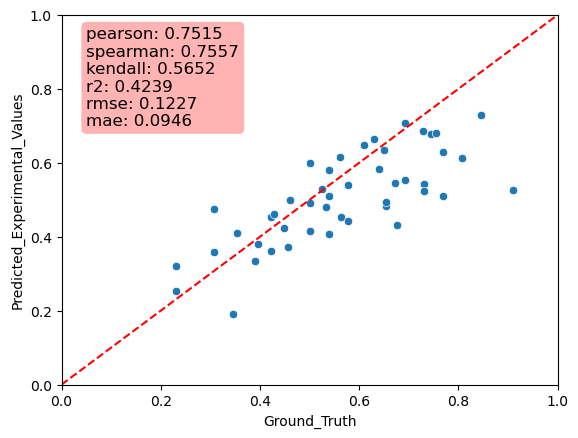

In [12]:
embedder.eval(); chemix.eval()
with torch.no_grad():
    out = embedder.graphs_to_mixtures(test_gr, test_indices, device="cpu")
    y_pred = chemix(out)
# calculate a bunch of metrics on the results to compare
leaderboard_metrics = {}
for name, func in TORCH_METRIC_FUNCTIONS.items():
    leaderboard_metrics[name] = func(y_pred.flatten(), y_test.flatten()).detach().cpu().item()
pprint(leaderboard_metrics)
leaderboard_metrics = pd.DataFrame(leaderboard_metrics, index=['metrics']).transpose()
y_pred = y_pred.detach().cpu().numpy().flatten()
y_test = y_test.detach().cpu().numpy().flatten()
leaderboard_predictions = pd.DataFrame({
    'Predicted_Experimental_Values': y_pred, 
    'Ground_Truth': y_test,
    'MAE': np.abs(y_pred - y_test),
}, index=range(len(y_pred)))
# plot the predictions
ax = sns.scatterplot(data=leaderboard_predictions, x='Ground_Truth', y='Predicted_Experimental_Values')
ax.plot([0,1], [0,1], 'r--')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.annotate(''.join(f'{k}: {v["metrics"]:.4f}\n' for k, v in leaderboard_metrics.iterrows()).strip(),
        xy=(0.05,0.7), xycoords='axes fraction',
        # textcoords='offset points',
        size=12,
        bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"))
plt.show()

# Final Results on DREAMix model on 2024 DREAM Olfactory Mixture Challenge
## Ensemble of Top 2 RMSE and Top 8 Pearson Correlation optimized models on the Leaderboard Competition Dataset

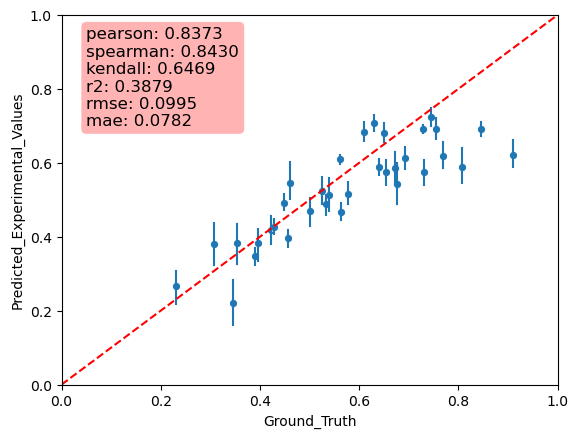

## Comparison of baseline models (XGBoost, POM, DREAMix, and Ensemble Models)

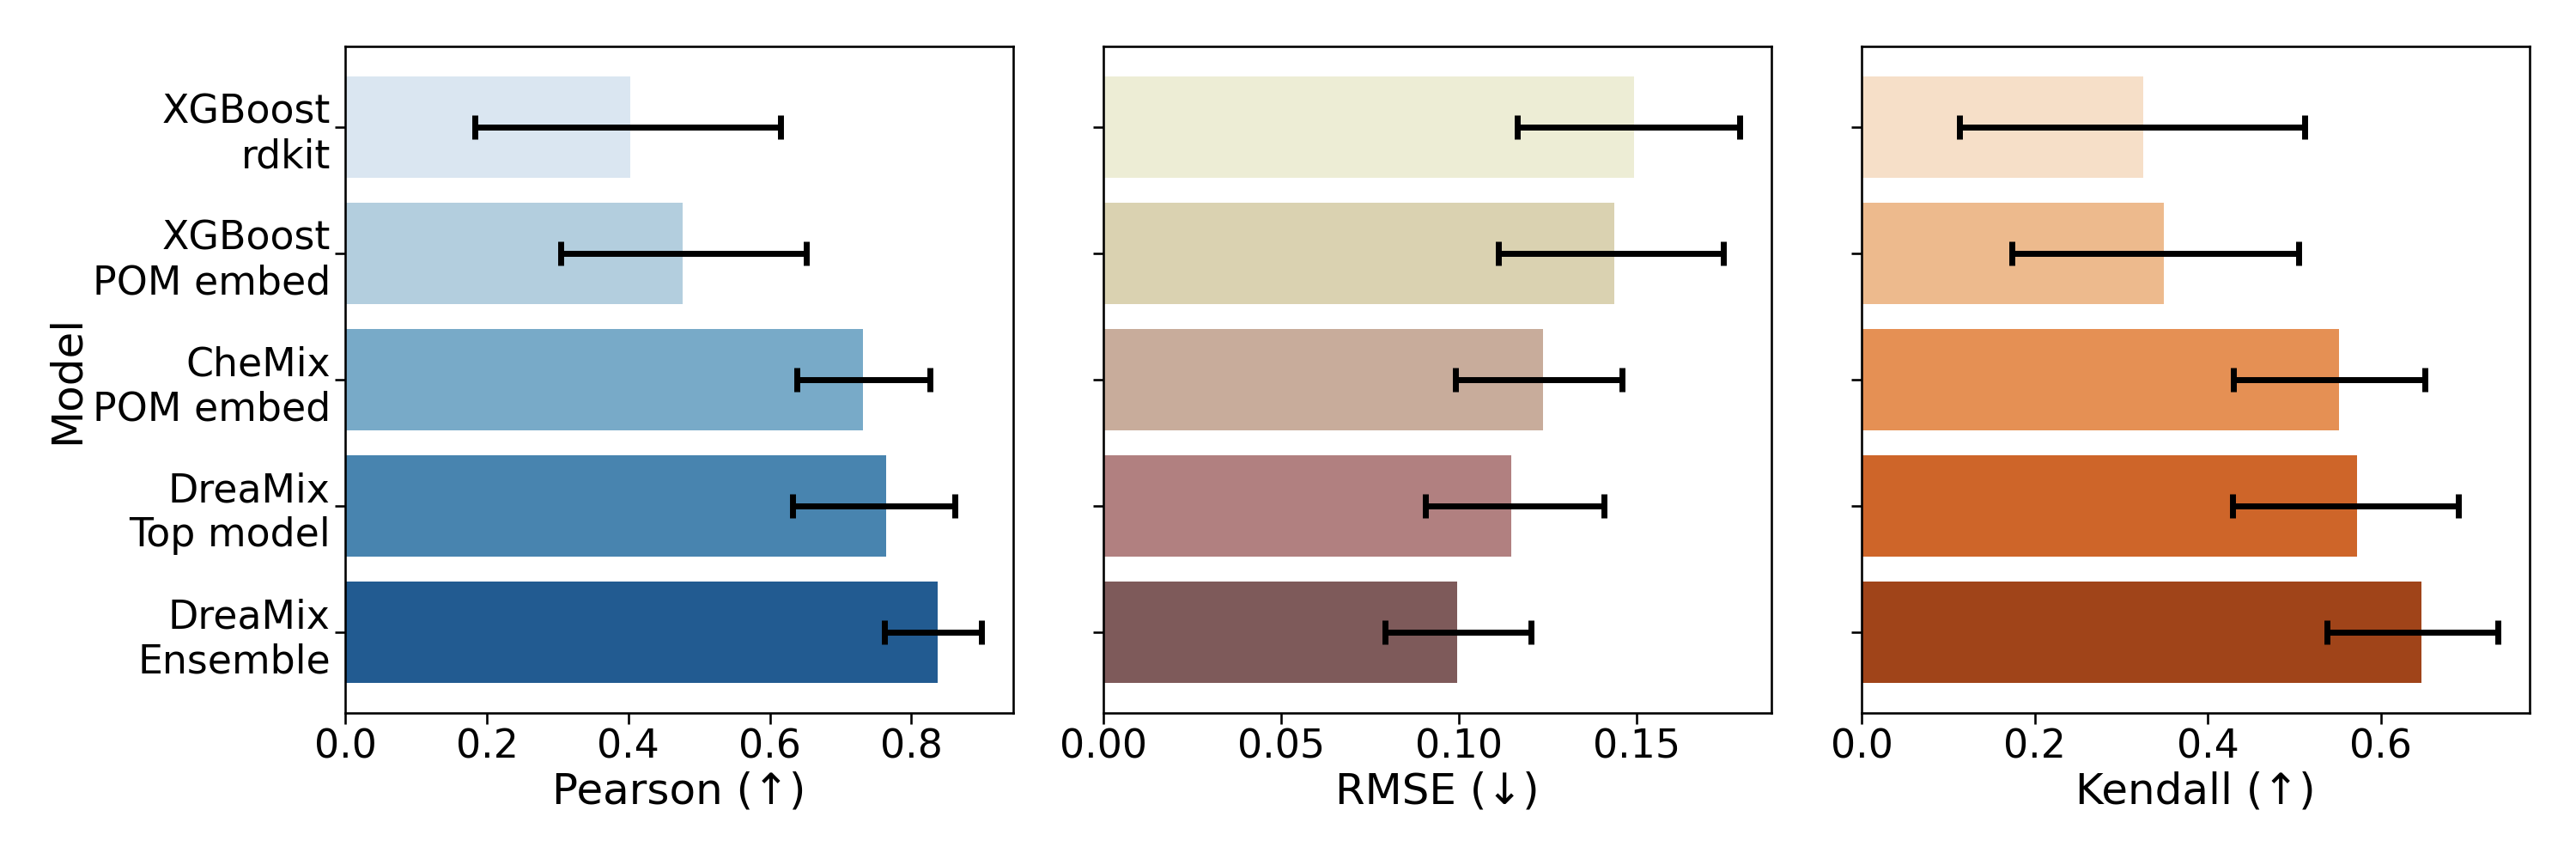